# Compressed screen simulation

In [36]:
import numpy as np
from scipy.optimize import minimize, nnls, LinearConstraint, lsq_linear
import sklearn.linear_model as lm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import einops
import pandas as pd

import scipy.sparse as sparse

### Define the experiment parameters

In [37]:
num_markers = 10
num_measurements = 5
num_perturb = 100
num_bins = 5
num_cells = int(1e5)
seq_depth = 100000

# Divide by normal quantiles
gates_min = stats.norm.ppf(np.linspace(0, 1, num_bins+1))[:-1]
gates_max = stats.norm.ppf(np.linspace(0, 1, num_bins+1))[1:]
repeated_gates_max = np.repeat(gates_max[np.newaxis, :], num_perturb, axis=0)
repeated_gates_min = np.repeat(gates_min[np.newaxis, :], num_perturb, axis=0)

num_markers_per_pool = 3
pooled_gates_min = stats.norm.ppf(np.linspace(0, 1, num_bins+1), scale=np.sqrt(num_markers_per_pool))[:-1]
pooled_gates_max = stats.norm.ppf(np.linspace(0, 1, num_bins+1), scale=np.sqrt(num_markers_per_pool))[1:]
pooled_repeated_gates_max = np.repeat(pooled_gates_max[np.newaxis, :], num_perturb, axis=0)
pooled_repeated_gates_min = np.repeat(pooled_gates_min[np.newaxis, :], num_perturb, axis=0)

### Define the ground truth variables

- `D`: True effect size of each guide on expression, `num_perturb x num_markers`
- `S`: Guide assignment for single cells, `num_cells x num_perturb`

In [38]:
D = stats.norm.rvs(size=(num_perturb, num_markers), scale=2)
# D[np.absolute(D) < -0.5] = 0
# D[np.random.choice([True, False], p=[0.8, 0.2], size=D.shape)] = 0
S = np.zeros((num_cells, num_perturb))
for row in range(num_cells):
    S[row, np.random.randint(num_perturb)]=1
# print('Sanity check, guide assignment per cell', S.sum(axis=1))

### Generate single cells

Single cell expression

In [39]:
Z = stats.norm.rvs(S@D)

<AxesSubplot:ylabel='Density'>

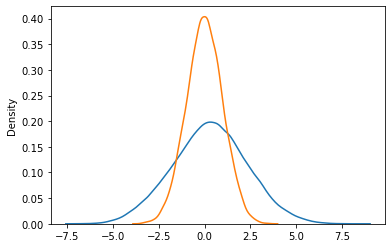

In [40]:
sns.kdeplot(Z[:, 0])
sns.kdeplot(stats.norm.rvs(size=10000))

### Sort and sequence for "vanilla" screen

In [41]:
def sort_sequence_vanilla(Z, S):
    
    num_cells_per_measurement = int(num_cells/num_markers)

    S_list = np.array_split(S, num_markers)
    Z_list = np.array_split(Z, num_markers)
    
    Y_vanilla = np.zeros((num_markers, num_bins, num_perturb))

    for i in range(num_markers):

        for b in range(num_bins):

            cell_filter = (Z_list[i][:, i] > gates_min[b]) & (Z_list[i][:, i] < gates_max[b])

            Y_vanilla[i,b,:] = S_list[i][cell_filter].mean(axis=0)
    
    return Y_vanilla

In [42]:
Y_vanilla = sort_sequence_vanilla(Z,S)

### MLE approach

In [43]:
bin_probs = [((Z[:, [i]] < gates_max[np.newaxis, :]) & (Z[:, [i]] > gates_min[np.newaxis, :])).mean(axis=0) for i in range(num_markers)]

In [44]:
def theoretical_sort_sequence_vanilla(D_):
    

    Y_ = np.zeros((num_markers, num_bins, num_perturb))
    
    for i in range(num_markers):
        
        mean = D_[:, [i]]
        stdn = stats.norm(loc=np.zeros(mean.shape))
        grv = stats.norm(loc=mean)
        
        Y_[i,:,:] = ( (grv.cdf(repeated_gates_max)-grv.cdf(repeated_gates_min)) * (1/num_perturb) / bin_probs[i]).T #(stdn.cdf(repeated_gates_max)-stdn.cdf(repeated_gates_min)) ).T
        
#         for b in range(num_bins):
            
#             for p in range(num_perturb):
                
#                 mean = D_[p, i]
#                 stdn = stats.norm(loc=0)
#                 grv = stats.norm(loc=mean)
#                 Y_[i,b,p] = (grv.cdf(gates_max[b])-grv.cdf(gates_min[b])) * (1/num_perturb) / (stdn.cdf(gates_max[b])-stdn.cdf(gates_min[b]))
    return Y_

In [45]:
def vanilla_mle_objective(D_):
    
    D_ = D_.reshape((num_perturb, num_markers))
    
    Y_ = theoretical_sort_sequence_vanilla(D_)
    
    return np.log((np.absolute(Y_vanilla - Y_)).mean() + 1e-4*np.linalg.norm(D_, ord=1)/(num_perturb*num_markers))

In [46]:
D0 = stats.norm.rvs(size=D.shape, scale=0.1)
D0[np.random.choice([True, False], p=[0.9, 0.1], size=D0.shape)] = 0

vanilla_mle_objective(D0)

-4.5552926830900935

In [47]:
%%time
vanilla_mle_objective(D)

CPU times: user 20 ms, sys: 2.22 ms, total: 22.2 ms
Wall time: 20.5 ms


-6.359030084458597

In [48]:
%%time
vanilla_mle_objective(np.zeros(D.shape))

CPU times: user 20.3 ms, sys: 1.53 ms, total: 21.8 ms
Wall time: 20.8 ms


-4.555230048400493

In [49]:
res = minimize(vanilla_mle_objective, D0, method='L-BFGS-B', options={'maxiter':100, 'disp':True})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.55529D+00    |proj g|=  7.69340D-04


 This problem is unconstrained.



At iterate    1    f= -4.77084D+00    |proj g|=  1.19256D-03

At iterate    2    f= -5.02267D+00    |proj g|=  1.52518D-03

At iterate    3    f= -5.10985D+00    |proj g|=  1.60147D-03

At iterate    4    f= -5.23839D+00    |proj g|=  1.90559D-03

At iterate    5    f= -5.38272D+00    |proj g|=  2.19309D-03

At iterate    6    f= -5.58440D+00    |proj g|=  2.68763D-03

At iterate    7    f= -5.67463D+00    |proj g|=  2.93197D-03

At iterate    8    f= -5.91201D+00    |proj g|=  3.64953D-03

At iterate    9    f= -5.99192D+00    |proj g|=  3.85452D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1000      9     15   

In [50]:
D_hat = res.x.reshape((num_perturb, num_markers))

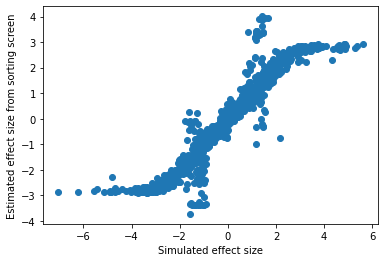

In [51]:
plt.scatter(D.ravel(), D_hat.ravel())
plt.xlabel('Simulated effect size');
plt.ylabel('Estimated effect size from sorting screen');

### Sort and sequence the "pooled" screen

In [52]:
pooling_matrix = np.zeros((num_markers, num_measurements))
for idx in range(num_measurements):
    pooling_matrix[np.random.choice(num_markers, size=num_markers_per_pool, replace=False), idx] = 1
    

In [53]:
pooling_matrix

array([[1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0.]])

In [54]:
num_cells_per_measurement = int(num_cells/num_measurements)

S_list = np.array_split(S, num_measurements)

Zp = Z@pooling_matrix
Zp_list = np.array_split(Zp, num_measurements)


In [55]:
Y_pooled = np.zeros((num_measurements, num_bins, num_perturb))
for i in range(num_measurements):
    
    for b in range(num_bins):
            
        cell_filter = (Zp_list[i][:, i] > pooled_gates_min[b])& (Zp_list[i][:, i] < pooled_gates_max[b])
        
        Y_pooled[i,b,:] = S_list[i][cell_filter].mean(axis=0)

In [56]:
bin_probs = [((Zp[:, [i]] < pooled_gates_max[np.newaxis, :]) & (Zp[:, [i]] > pooled_gates_min[np.newaxis, :])).mean(axis=0) for i in range(num_measurements)]


In [57]:
def theoretical_sort_sequence_pooled(D_):
    

    Y_ = np.zeros((num_measurements, num_bins, num_perturb))
    
    pooled_means = D_@pooling_matrix
    
    for i in range(num_measurements):
        
        mean = pooled_means[:, [i]]
        grv = stats.norm(loc=mean, scale=np.sqrt(num_markers_per_pool))
        
        Y_[i,:,:] = ( (grv.cdf(pooled_repeated_gates_max)-grv.cdf(pooled_repeated_gates_min)) * (1/num_perturb) / bin_probs[i]).T #(stdn.cdf(repeated_gates_max)-stdn.cdf(repeated_gates_min)) ).T
        
    return Y_

In [58]:
alpha = 0.0001
def pooled_mle_objective(D_):
    
    D_ = D_.reshape((num_perturb, num_markers))
    
    Y_ = theoretical_sort_sequence_pooled(D_)
    
    return (np.absolute(Y_pooled - Y_)).mean() + alpha*np.absolute(D_).mean()

In [59]:
pooled_mle_objective(D)

0.0014014911040737062

In [60]:
D0 = stats.norm.rvs(size=D.shape, scale=0.1)
# D0[np.random.choice([True, False], p=[0.9, 0.1], size=D0.shape)] = 0

pooled_mle_objective(D0)

0.010342872546018197

In [61]:
%%time
pooled_mle_objective(np.zeros(D.shape))

CPU times: user 24.2 ms, sys: 1.79 ms, total: 25.9 ms
Wall time: 7.98 ms


0.010311633640973289

In [62]:
res = minimize(pooled_mle_objective, D0, method='L-BFGS-B', options={'maxiter':100, 'disp':True})

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03429D-02    |proj g|=  3.24228D-05

At iterate    1    f=  9.14247D-03    |proj g|=  3.54567D-05

At iterate    2    f=  7.80608D-03    |proj g|=  3.52750D-05

At iterate    3    f=  6.51162D-03    |proj g|=  3.18327D-05

At iterate    4    f=  5.68288D-03    |proj g|=  3.66461D-05

At iterate    5    f=  5.15465D-03    |proj g|=  2.70481D-05

At iterate    6    f=  4.79020D-03    |proj g|=  3.59786D-05

At iterate    7    f=  4.33551D-03    |proj g|=  3.52949D-05

At iterate    8    f=  4.03699D-03    |proj g|=  3.94586D-05

At iterate    9    f=  3.67300D-03    |proj g|=  3.00229D-05

At iterate   10    f=  3.51647D-03    |proj g|=  2.62901D-05

At iterate   11    f=  3.43227D-03    |proj g|=  2.25926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

In [63]:
D_hat_pooled = res.x.reshape((num_perturb, num_markers))

In [67]:
stats.pearsonr(D.ravel(), D_hat_pooled.ravel())

(0.4992808133579285, 3.679204010419736e-64)

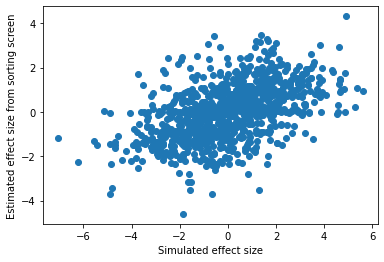

In [64]:
plt.scatter()
plt.xlabel('Simulated effect size');
plt.ylabel('Estimated effect size from sorting screen');

### Naive approch

There's essentially no signal. The "signal" comes from the part of the vanilla screen that's just noise.

In [157]:
def pooled_screen_naive(Y, meta):

    Y_flat = np.log(einops.rearrange(Y, 'i j k -> (i j) k')+1e-3)
    X = pooling_matrix[:, meta['measurement'].astype(int)].T
    X = X * meta[['level']].values
    sns.heatmap(X)
    model = lm.Lasso(alpha=0.05, fit_intercept=False)
    model.fit(X,Y_flat)
    return model.coef_

Text(0, 0.5, 'sgRNA LFC from pooled experiment')

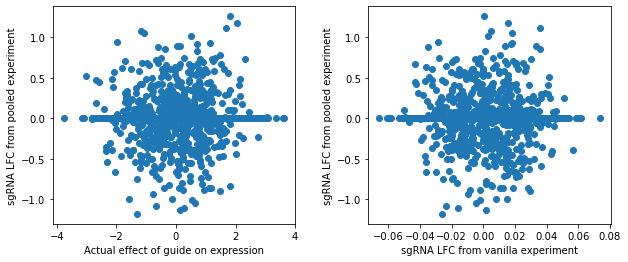

In [159]:
plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 2, 1)
plt.scatter(D.T.ravel(), D_hat_pooled.ravel())
plt.xlabel('Actual effect of guide on expression')
plt.ylabel('sgRNA LFC from pooled experiment')

plt.subplot(1, 2, 2)
plt.scatter(D_hat_vanilla.ravel(),D_hat_pooled.ravel())
plt.xlabel('sgRNA LFC from vanilla experiment')
plt.ylabel('sgRNA LFC from pooled experiment')


### Data augmentation approach

Pretend true expression is the bins. "Generate" data from the pseudobulks

In [ ]:
generated_data = []

for i in range(num_measurements):
    
    for b in range(num_bins):
        
        for p in range(num_perturb):
            
            

### Analyize vanilla screen

In [ ]:
Y_vanilla_flat = einops.rearrange(Y_vanilla, 'i j k -> (i j) k')
X_vanilla = 

In [157]:
Y_vanilla.shape

(15, 2, 100)

In [158]:
Y_pooled.shape

(5, 2, 100)

array([[0.00234742, 0.00234742, 0.00704225, ..., 0.00704225, 0.00469484,
        0.01877934],
       [0.00422833, 0.00634249, 0.00211416, ..., 0.01691332, 0.01057082,
        0.01268499],
       [0.0022779 , 0.00455581, 0.02050114, ..., 0.01138952, 0.01594533,
        0.00455581],
       ...,
       [0.        , 0.02455357, 0.01785714, ..., 0.00223214, 0.00892857,
        0.00223214],
       [0.02136752, 0.01282051, 0.        , ..., 0.01709402, 0.00854701,
        0.01709402],
       [0.        , 0.        , 0.02137767, ..., 0.0023753 , 0.00475059,
        0.00950119]])